In [1]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import ipdb
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import visdom

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox, vis_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

/datasets/home/22/122/tan/simple-faster-rcnn-pytorch/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')
/datasets/home/22/122/tan/simple-faster-rcnn-pytorch/utils/vis_tool.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-pac

In [2]:
def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result

In [3]:
def train(**kwargs):
    opt._parse(kwargs)
    return opt
opt = train()

======user config========
{'caffe_pretrain': False,
 'caffe_pretrain_path': 'checkpoints/vgg16_caffe.pth',
 'data': 'voc',
 'debug_file': '/tmp/debugf',
 'env': 'faster-rcnn',
 'epoch': 14,
 'load_path': None,
 'lr': 0.001,
 'lr_decay': 0.1,
 'max_size': 1000,
 'min_size': 600,
 'num_workers': 8,
 'plot_every': 40,
 'port': 8097,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'test_num': 10000,
 'test_num_workers': 8,
 'use_adam': True,
 'use_chainer': False,
 'use_drop': False,
 'voc_data_dir': '/datasets/home/22/122/tan/Fast-Pedestrian-Tracking/data',
 'weight_decay': 0.0005}
==========end============


In [4]:
dataset = Dataset(opt)
dataloader = data_.DataLoader(dataset, \
                              batch_size=1, \
                              shuffle=True, \
                              # pin_memory=True,
                              num_workers=opt.num_workers)
testset = TestDataset(opt, split='val')
test_dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False, \
                                   pin_memory=True
                                   )
print(f"TRAIN SET: {len(dataloader)} | TEST SET: {len(test_dataloader)}")

/datasets/home/22/122/tan/Fast-Pedestrian-Tracking/data/data_train.csv
/datasets/home/22/122/tan/Fast-Pedestrian-Tracking/data/data_val.csv
TRAIN SET: 19038 | TEST SET: 2131


In [5]:
# Single batch
img, bbox, label_, scale = next(iter(dataloader))
scale = at.scalar(scale)
img = img.numpy()
bbox = bbox.numpy()
print(img.shape, img.min(), img.max(), img.dtype)
print(bbox.shape, bbox.min(), bbox.max(), bbox.dtype)
# trainer.train_step(img, bbox, label, scale)

(1, 3, 600, 800) -2.117904 2.64 float32
(1, 3, 4) 26.055489 540.66705 float32


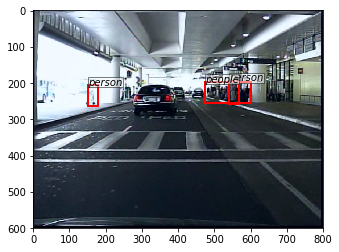

In [6]:
ori_img_ = inverse_normalize(at.tonumpy(img[0]))
gt_img = vis_bbox(ori_img_,
                     at.tonumpy(bbox[0]),
                     at.tonumpy(label_[0]))
plt.show()

In [7]:
faster_rcnn = FasterRCNNVGG16()
print('model construct completed')
trainer = FasterRCNNTrainer(faster_rcnn).cuda()
best_map = 0
lr_ = opt.lr

Preparing Mask


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


model construct completed


In [ ]:
for epoch in range(opt.epoch):
    trainer.reset_meters()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for ii, (img, bbox_, label_, scale) in pbar:
        bbox_tmp = bbox_.clone()
        bbox_[:, :, 2] += bbox_[:, :, 0]
        bbox_[:, :, 3] += bbox_[:, :, 1]
        bbox_[:, :, 0], bbox_[:, :, 1] = bbox_[:, :, 1], bbox_[:, :, 0]
        bbox_[:, :, 2], bbox_[:, :, 3] = bbox_[:, :, 3], bbox_[:, :, 2]
        scale = at.scalar(scale)
        
        img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
        losses = trainer.train_step(img, bbox, label, scale)
        if ii % 10 == 0:
            rpnloc = losses[0].cpu().data.numpy()
            rpncls = losses[1].cpu().data.numpy()
            roiloc = losses[2].cpu().data.numpy()
            roicls = losses[3].cpu().data.numpy()
            tot = losses[4].cpu().data.numpy()
            pbar.set_description(f"Epoch: {epoch} | Batch: {ii} | RPNLoc Loss: {rpnloc:.4f} | RPNclc Loss: {rpncls:.4f} | ROIloc Loss: {roiloc:.4f} | ROIclc Loss: {roicls:.4f} | Total Loss: {tot:.4f}")
        if (ii + 1) % 1000 == 0:
            print(trainer.get_meter_data())
            ori_img_ = inverse_normalize(at.tonumpy(img[0]))
            gt_img = vis_bbox(ori_img_,
                                 at.tonumpy(bbox_tmp[0]),
                                 at.tonumpy(label_[0]))
            plt.show()

            # plot predicti bboxes
            _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
            pred_img = vis_bbox(ori_img_,
                                   at.tonumpy(_bboxes[0]),
                                   at.tonumpy(_labels[0]).reshape(-1),
                                   at.tonumpy(_scores[0]))
            plt.show()
            
            
    eval_result = eval(test_dataloader, faster_rcnn, test_num=1000)
    lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
    log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                      str(trainer.get_meter_data()))

    if eval_result['map'] > best_map:
        best_map = eval_result['map']
        best_path = trainer.save(best_map=best_map)
    if epoch == 9:
        trainer.load(best_path)
        trainer.faster_rcnn.scale_lr(opt.lr_decay)
        lr_ = lr_ * opt.lr_decay

    if epoch == 13: 
        break
        

Epoch: 0 | Batch: 0 | RPNLoc Loss: 10.7751 | RPNclc Loss: 0.7024 | ROIloc Loss: 0.0000 | ROIclc Loss: 3.1288 | Total Loss: 14.6063:   0%|          | 2/19038 [00:03<8:30:19,  1.61s/it] /datasets/home/22/122/tan/simple-faster-rcnn-pytorch/model/utils/bbox_tools.py:68: RuntimeWarning: overflow encountered in multiply
  h = xp.exp(dh) * src_height[:, xp.newaxis]
/datasets/home/22/122/tan/simple-faster-rcnn-pytorch/model/utils/bbox_tools.py:69: RuntimeWarning: overflow encountered in multiply
  w = xp.exp(dw) * src_width[:, xp.newaxis]
Epoch: 0 | Batch: 440 | RPNLoc Loss: 4.0322 | RPNclc Loss: 0.8096 | ROIloc Loss: 0.0024 | ROIclc Loss: 0.1203 | Total Loss: 4.9645:   2%|▏         | 441/19038 [03:53<2:43:59,  1.89it/s] 

In [1]:
eval_result = eval(test_dataloader, faster_rcnn, test_num=100)
lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                  str(trainer.get_meter_data()))

if eval_result['map'] > best_map:
    best_map = eval_result['map']
    best_path = trainer.save(best_map=best_map)
if epoch == 9:
    trainer.load(best_path)
    trainer.faster_rcnn.scale_lr(opt.lr_decay)
    lr_ = lr_ * opt.lr_decay

NameError: name 'test_dataloader' is not defined

In [11]:
print(log_info)

lr:0.001, map:0.47826288783812787,loss:{'rpn_loc_loss': 0.064478582827022, 'rpn_cls_loss': 0.17955750928700265, 'roi_loc_loss': 0.3624453095047117, 'roi_cls_loss': 0.3703646318211248, 'total_loss': 0.9768460336615438}


In [12]:
trainer.get_meter_data()

{'roi_cls_loss': 0.3703646318211248,
 'roi_loc_loss': 0.3624453095047117,
 'rpn_cls_loss': 0.17955750928700265,
 'rpn_loc_loss': 0.064478582827022,
 'total_loss': 0.9768460336615438}